# Calculate UMAP embeddings with different parameters

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import librosa
import numba

In [2]:
import math
from scipy.signal import butter, lfilter

In [3]:
from preprocessing_functions import calc_zscore, pad_spectro, create_padded_data

In [4]:
from preprocessing_functions import preprocess_spec_numba,preprocess_spec_numba_fl, pad_transform_spectro

In [5]:
from spectrogramming_functions import generate_mel_spectrogram, generate_stretched_spectrogram

In [6]:
wd = os.getcwd()

DF = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed", "df_focal_reduced.pkl")
OUT_COORDS = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "interim", "parameter_search", "grid_search")

## Generate dataframe for grid search

In [51]:
spec_df = pd.read_pickle(DF)
spec_df.shape

(6430, 34)

In [52]:
# Bandpass filters for calculating audio intensity
LOWCUT = 300.0
HIGHCUT = 3000.0

In [53]:
# Function that calculates intensity score from 
# amplitude audio data
# Input: 1D numeric numpy array (audio data)
# Output: Float (Intensity)
def calc_audio_intense_score(audio):
    res = 10*math.log((np.mean(audio**2)),10)
    return res

# Butter bandpass filter implementation:
# from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [42]:
from spectrogramming_functions import generate_spectrogram

In [12]:
# Using the band-pass filtered signal! 
raw_audios = spec_df['raw_audio']
srs = spec_df['samplerate_hz']

audio_filtered = [butter_bandpass_filter(audio, LOWCUT, HIGHCUT, sr, order=6) for audio,sr in zip(raw_audios, srs)]
spec_df['raw_audio_filtered'] = audio_filtered

In [13]:
# Spectrogramming parameters
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
FMAX = 4000
N_MFCC = 13
MAX_DURATION = 0.5

In [14]:
raw_specs = spec_df.apply(lambda row: generate_spectrogram(row['raw_audio'],
                                                           row['samplerate_hz'],
                                                           WINDOW,
                                                           FFT_WIN,
                                                           FFT_HOP), 
                        axis=1)
spec_df['raw_specs'] = raw_specs

In [15]:
raw_specs_filtered = spec_df.apply(lambda row: generate_spectrogram(row['raw_audio_filtered'],
                                                                    row['samplerate_hz'],
                                                                    WINDOW,
                                                                    FFT_WIN,
                                                                    FFT_HOP), 
                                   axis=1)
spec_df['raw_specs_filtered'] = raw_specs_filtered

In [17]:
raw_specs_stretched = spec_df.apply(lambda row: generate_stretched_spectrogram(row['raw_audio'],
                                                                               row['samplerate_hz'],
                                                                               row['duration_s'],
                                                                               WINDOW,
                                                                               FFT_WIN,
                                                                               FFT_HOP,
                                                                               MAX_DURATION), 
                                    axis=1)
spec_df['raw_specs_stretched'] = raw_specs_stretched

In [18]:
raw_specs_filtered_stretched = spec_df.apply(lambda row: generate_stretched_spectrogram(row['raw_audio_filtered'],
                                                                                        row['samplerate_hz'],
                                                                                        row['duration_s'],
                                                                                        WINDOW,
                                                                                        FFT_WIN,
                                                                                        FFT_HOP,
                                                                                        MAX_DURATION), 
                                             axis=1)
spec_df['raw_specs_filtered_stretched'] = raw_specs_filtered_stretched

In [19]:
spec_df.to_pickle(os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed", "df_grid.pkl"))

## Gridsearch

In [7]:
@numba.njit()
def unpack_specs(a,b):
    """
    Function that unpacks two specs that have been transformed into 
    a 1D array with preprocessing_functions.pad_transform_spec and 
    restores their original 2D shape

    Parameters
    ----------
    a,b : 1D numpy arrays (numeric)

    Returns
    -------
    spec_s, spec_l : 2D numpy arrays (numeric)
                     the restored specs 
    Example
    -------
    >>> 

    """

    a_shape0 = int(a[0])
    a_shape1 = int(a[1])
    b_shape0 = int(b[0])
    b_shape1 = int(b[1])

    spec_a= np.reshape(a[2:(a_shape0*a_shape1)+2], (a_shape0, a_shape1))
    spec_b= np.reshape(b[2:(b_shape0*b_shape1)+2], (b_shape0, b_shape1))
    
    len_a = a_shape1
    len_b = b_shape1
    
    # find bigger spec
    spec_s = spec_a
    spec_l = spec_b

    if len_a>len_b:
        spec_s = spec_b
        spec_l = spec_a
        
    return spec_s, spec_l

In [8]:
spec_df = pd.read_pickle(os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed", "df_grid.pkl"))

In [9]:
DEF_PREPROCESS_TYPE = 'zs'
DEF_METRIC_TYPE = 'euclidean'
DEF_DURATION_METHOD = 'pad'
DEF_MIN_DIST = 0
DEF_SPREAD = 1
DEF_N_NEIGHBORS = 15
DEF_N_COMPS = 3
DEF_DENOISE = 'no'
DEF_N_MELS = 40
DEF_F_UNIT = 'dB'

# Spectrogramming parameters
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
FMAX = 4000
N_MFCC = 13
MAX_DURATION = 0.5
MIN_OVERLAP = 0.9

In [10]:
from scipy.spatial.distance import correlation
from scipy.spatial.distance import cosine

In [11]:
def get_param_string():
    param_combi = "_".join([str(x) for x in [preprocess_type, metric_type, duration_method,
                                             min_dist, spread, n_neighbors, n_comps, input_type, 
                                             denoise, n_mels, f_unit, bp_filtered]])
    return param_combi

In [12]:
def calc_umap(data, outname, metric=DEF_METRIC_TYPE, min_dist=DEF_MIN_DIST, spread=DEF_SPREAD, n_neighbors=DEF_N_NEIGHBORS, n_comps=DEF_N_COMPS,n = 1):
    
    for i in range(n):
        reducer = umap.UMAP(n_components = n_comps, 
                            min_dist=min_dist,
                            spread=spread,
                            n_neighbors=n_neighbors,
                            metric=metric,
                            random_state=2204)

        embedding = reducer.fit_transform(data)
        print("\r"+outname, end="")
        np.savetxt(outname+'_'+str(i)+'.csv', embedding, delimiter=";")   

In [13]:
# *************** DO THE FULL GRIDSEARCH ***************

In [ ]:
n_neighbors = DEF_N_NEIGHBORS
spread = DEF_SPREAD
min_dist = DEF_MIN_DIST
n_comps = 3
input_type = "specs"

FMAX = 4000

for duration_method in ['pad', 'pairwise-pad', 'stretched', 'timeshift-pad', 'timeshift-overlap', 'overlap']:
    for preprocess_type in ['no', 'zs', 'zs-fl-ce']:
        for metric_type in ['cosine', 'euclidean', 'correlation', 'manhattan']:
            for denoise in ['yes', 'no']:
                for n_mels in [0, 10, 20, 30, 40, 50]:
                    for f_unit in ['dB', 'magnitude']:
                        for bp_filtered in ['yes', 'no']:                            
                            outname = os.path.join(os.path.sep, OUT_COORDS, get_param_string())
                            #print("\r"+outname, end="")                   
                            try:
                                # select dataframe column
                                if bp_filtered=='yes':
                                    if duration_method=='stretched':
                                        specs = spec_df.raw_specs_filtered_stretched.copy()
                                    else:
                                        specs = spec_df.raw_specs_filtered.copy()
                                else:
                                    if duration_method=='stretched':
                                        specs = spec_df.raw_specs_stretched.copy()
                                    else:
                                        specs = spec_df.raw_specs.copy()


                                # Mel transform
                                if n_mels>0:
                                    srs = spec_df.samplerate_hz.copy()
                                    specs = [librosa.feature.melspectrogram(S=s, sr=sr, n_mels=n_mels, fmax=FMAX) for s, sr in zip(specs, srs)]
                                else:
                                    # Problem: Because of the varying samplerate, the non-mel-transformed spectrograms are not all of the same height!!
                                    # So if I'm using them, I need to cut the ones with the more frequency range.
                                    n_bins = [s.shape[0] for s in specs]
                                    min_bins = np.min(n_bins)
                                    specs = [s[0:min_bins,:] for s in specs]

                                # Spectrogram intensity unit
                                if f_unit=="dB":
                                    specs = [librosa.power_to_db(s, ref=np.max) for s in specs]


                                # Denoising
                                if denoise=='yes':
                                    specs = [(s-np.median(s, axis=0)) for s in specs]

                                # Pre-processing
                                if preprocess_type=='zs':
                                    specs = [calc_zscore(s) for s in specs]
                                elif preprocess_type=='zs-fl-ce':
                                    specs = [calc_zscore(s) for s in specs] 
                                    specs = [np.where(s<0,0,s) for s in specs]
                                    specs = [np.where(s>3,3,s) for s in specs]


                                # Duration method
                                if duration_method in ['pad', 'stretched']:
                                    data = create_padded_data(specs)
                                    calc_umap(data, outname=outname, metric = metric_type)

                                else:
                                    n_bins = specs[0].shape[0]
                                    maxlen = np.max([spec.shape[1] for spec in specs]) * n_bins + 2
                                    trans_specs = [pad_transform_spectro(spec, maxlen) for spec in specs]
                                    data = np.asarray(trans_specs)


                                    # set spec_dist depending on metric_type!!
                                    if metric_type=='euclidean':
                                        @numba.njit()
                                        def spec_dist(a,b,size):
                                            dist = np.sqrt((np.sum(np.subtract(a,b)*np.subtract(a,b)))) / np.sqrt(size)
                                            return dist

                                    elif metric_type=='manhattan':
                                        @numba.njit()
                                        def spec_dist(a,b,size):
                                            dist = (np.sum(np.abs(np.subtract(a,b)))) / size
                                            return dist

                                    elif metric_type=='cosine':
                                        @numba.njit()
                                        def spec_dist(a,b,size):
                                            # turn into unit vectors by dividing each vector field by magnitude of vector
                                            dot_product = np.sum(a*b)
                                            a_magnitude = np.sqrt(np.sum(a*a))
                                            b_magnitude = np.sqrt(np.sum(b*b))
                                            dist = 1 - dot_product/(a_magnitude*b_magnitude)
                                            return dist

                                    elif metric_type=='correlation':
                                        @numba.njit()
                                        def spec_dist(a,b,size):
                                            a_meandiff = a - np.mean(a)
                                            b_meandiff = b - np.mean(b)
                                            dot_product =  np.sum(a_meandiff*b_meandiff)                                  
                                            a_meandiff_magnitude = np.sqrt(np.sum(a_meandiff*a_meandiff))
                                            b_meandiff_magnitude = np.sqrt(np.sum(b_meandiff*b_meandiff))
                                            dist = 1 - dot_product/(a_meandiff_magnitude * b_meandiff_magnitude)
                                            return dist
                                    
                                    
                                    # for duration_method in ['pad', 'pairwise-pad', 'stretch', 'timeshift-pad', 'timeshift-overlap', 'overlap']:
                                    if duration_method=='pairwise-pad':
                                        @numba.njit()
                                        def calc_pairwise_pad(a, b):
                                            spec_s, spec_l = unpack_specs(a,b)
                                            n_padding = int(spec_l.shape[1] - spec_s.shape[1])

                                            n_bins = spec_s.shape[0]

                                                    # pad the smaller spec (if necessary)
                                            if n_padding!=0:
                                                pad = np.full((n_bins, n_padding), 0.0)
                                                spec_s_padded = np.concatenate((spec_s, pad), axis=1)
                                                spec_s_padded = spec_s_padded.astype(np.float64)
                                            else:
                                                spec_s_padded = spec_s.astype(np.float64)

                                                    # compute distance

                                            spec_s_padded = np.reshape(spec_s_padded, (-1)).astype(np.float64)
                                            spec_l = np.reshape(spec_l, (-1)).astype(np.float64)
                                            size = spec_l.shape[0]

                                            dist = spec_dist(spec_s_padded, spec_l, size)
                                            return dist

                                        calc_umap(data, outname=outname, metric = calc_pairwise_pad)

                                    elif duration_method=='timeshift-pad':
                                        @numba.njit()
                                        def calc_timeshift_pad(a,b):
                                            spec_s, spec_l = unpack_specs(a,b)

                                            len_s = spec_s.shape[1]
                                            len_l = spec_l.shape[1]

                                            nfreq = spec_s.shape[0] 

                                                # define start position
                                            min_overlap_frames = int(MIN_OVERLAP * len_s)
                                            start_timeline = min_overlap_frames-len_s
                                            max_timeline = len_l - min_overlap_frames

                                            n_of_calculations = int((((max_timeline+1-start_timeline)+(max_timeline+1-start_timeline))/2) +1)

                                            distances = np.full((n_of_calculations),999.)

                                            count=0

                                            for timeline_p in range(start_timeline, max_timeline+1,2):
                                                    #print("timeline: ", timeline_p)
                                                    # mismatch on left side
                                                if timeline_p < 0:
                                                    len_overlap = len_s - abs(timeline_p)
                                                    pad_s = np.full((nfreq, (len_l-len_overlap)),0.)
                                                    pad_l = np.full((nfreq, (len_s-len_overlap)),0.)

                                                    s_config = np.append(spec_s, pad_s, axis=1).astype(np.float64)
                                                    l_config = np.append(pad_l, spec_l, axis=1).astype(np.float64)

                                                    # mismatch on right side
                                                elif timeline_p > (len_l-len_s):

                                                    len_overlap = len_l - timeline_p

                                                    pad_s = np.full((nfreq, (len_l-len_overlap)),0.)
                                                    pad_l = np.full((nfreq, (len_s-len_overlap)),0.)

                                                    s_config = np.append(pad_s, spec_s, axis=1).astype(np.float64)
                                                    l_config = np.append(spec_l, pad_l, axis=1).astype(np.float64)

                                                    # no mismatch on either side
                                                else:
                                                    len_overlap = len_s
                                                    start_col_l = timeline_p
                                                    end_col_l = start_col_l + len_overlap

                                                    pad_s_left = np.full((nfreq, start_col_l),0.)
                                                    pad_s_right = np.full((nfreq, (len_l - end_col_l)),0.)

                                                    l_config = spec_l.astype(np.float64)
                                                    s_config = np.append(pad_s_left, spec_s, axis=1).astype(np.float64)
                                                    s_config = np.append(s_config, pad_s_right, axis=1).astype(np.float64)

                                                size = s_config.shape[0]*s_config.shape[1]
                                                distances[count] = spec_dist(s_config, l_config, size)
                                                count = count + 1


                                            min_dist = np.min(distances)
                                            return min_dist
                                            
                                        calc_umap(data, outname=outname, metric = calc_timeshift_pad)


                                    elif duration_method=='timeshift-overlap':
                                        @numba.njit()
                                        def calc_timeshift(a,b):
                                            spec_s, spec_l = unpack_specs(a,b)  
                                            len_l = spec_l.shape[1]
                                            len_s = spec_s.shape[1]


                                                # define start position
                                            min_overlap_frames = int(MIN_OVERLAP * len_s)
                                            start_timeline = min_overlap_frames-len_s
                                            max_timeline = len_l - min_overlap_frames

                                            n_of_calculations = (max_timeline+1-start_timeline)+(max_timeline+1-start_timeline)

                                            distances = np.full((n_of_calculations),999.)

                                            count=0

                                            for timeline_p in range(start_timeline, max_timeline+1):
                                                    # mismatch on left side
                                                if timeline_p < 0:
                                                    start_col_l = 0
                                                    len_overlap = len_s - abs(timeline_p)

                                                    end_col_l = start_col_l + len_overlap

                                                    end_col_s = len_s # until the end
                                                    start_col_s = end_col_s - len_overlap

                                                    # mismatch on right side
                                                elif timeline_p > (len_l-len_s):
                                                    start_col_l = timeline_p
                                                    len_overlap = len_l - timeline_p
                                                    end_col_l = len_l

                                                    start_col_s = 0
                                                    end_col_s = start_col_s + len_overlap

                                                    # no mismatch on either side
                                                else:
                                                    start_col_l = timeline_p
                                                    len_overlap = len_s
                                                    end_col_l = start_col_l + len_overlap

                                                    start_col_s = 0
                                                    end_col_s = len_s # until the end


                                                s_s = spec_s[:,start_col_s:end_col_s].astype(np.float64)
                                                s_l = spec_l[:,start_col_l:end_col_l].astype(np.float64)
                                                size = s_s.shape[0]*s_s.shape[1]
                                                distances[count] = spec_dist(s_s, s_l, size)

                                                count = count + 1

                                            min_dist = np.min(distances)                                              
                                            return min_dist
                                        
                                        calc_umap(data, outname=outname, metric = calc_timeshift)


                                    elif duration_method=='overlap':
                                        @numba.njit()
                                        def calc_overlap_only(a,b): 
                                            spec_s, spec_l = unpack_specs(a,b)

                                                #only use overlap section from longer spec
                                            spec_l = spec_l[:spec_s.shape[0],:spec_s.shape[1]]

                                            spec_s = spec_s.astype(np.float64)
                                            spec_l = spec_l.astype(np.float64)

                                            size = spec_s.shape[1]*spec_s.shape[0]   
                                            dist = spec_dist(spec_s, spec_l, size)

                                            return dist
                                            
                                        calc_umap(data, outname=outname, metric = calc_overlap_only)
                                    
                            except:
                                print("FAILED: ", get_param_string())
                                break

## Check results

In [18]:
n_neighbors = DEF_N_NEIGHBORS
spread = DEF_SPREAD
min_dist = DEF_MIN_DIST
n_comps = 3
input_type = "specs"
FMAX = 4000

expected_files = []

for duration_method in ['pad', 'pairwise-pad', 'stretched', 'timeshift-pad', 'timeshift-overlap', 'overlap']:
    for preprocess_type in ['no', 'zs', 'zs-fl-ce']:
        for metric_type in ['cosine', 'euclidean', 'correlation', 'manhattan']:
            for denoise in ['yes', 'no']:
                for n_mels in [0, 10, 20, 30, 40, 50]:
                    for f_unit in ['dB', 'magnitude']:
                        for bp_filtered in ['yes', 'no']:                            
                            expected_files.append(get_param_string()+'_0.csv')
print('Expected: ',len(expected_files))

all_embedding_files = list(sorted(os.listdir(OUT_COORDS)))
print('Observed: ',len(all_embedding_files))

missing_in_observed = [x for x in expected_files if x not in all_embedding_files]
print(len(missing_in_observed))
missing_in_observed

Expected:  3456
Observed:  3438
18


['zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_yes_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_no_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_yes_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_no_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_yes_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_no_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_yes_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_no_0.csv',
 'zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_40_magnitude_no_0.csv',
 'zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_yes_0.csv',
 'zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_no_0.csv',
 'zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_yes_0.csv',
 'zs-fl-ce_correlation_timeshift-overla

In [19]:
def get_params_from_filename(embedding_file):
    embedding_params_string = embedding_file.replace('.csv', '')
    embedding_params_list = embedding_params_string.split('_')
    return embedding_params_list

In [56]:
for f in missing_in_observed[:1]:
    print(f)

zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_yes_0.csv


In [57]:
preprocess_type, metric_type, duration_method,min_dist, spread, n_neighbors, n_comps, input_type, denoise, n_mels, f_unit, bp_filtered, n_repeat = get_params_from_filename(f)
min_dist = int(min_dist)
spread = int(spread)
n_neighbors = int(n_neighbors)
n_comps = int(n_comps)
n_mels = int(n_mels)

if bp_filtered=='yes':
    if duration_method=='stretched':
        specs = spec_df.raw_specs_filtered_stretched.copy()
    else:
        specs = spec_df.raw_specs_filtered.copy()
else:
    if duration_method=='stretched':
        specs = spec_df.raw_specs_stretched.copy()
    else:
        specs = spec_df.raw_specs.copy()
        
if n_mels>0:
    srs = spec_df.samplerate_hz.copy()
    specs = [librosa.feature.melspectrogram(S=s, sr=sr, n_mels=n_mels, fmax=FMAX) for s, sr in zip(specs, srs)]
else:
                                    # Problem: Because of the varying samplerate, the non-mel-transformed spectrograms are not all of the same height!!
                                    # So if I'm using them, I need to cut the ones with the more frequency range.
    n_bins = [s.shape[0] for s in specs]
    min_bins = np.min(n_bins)
    specs = [s[0:min_bins,:] for s in specs]
    
if denoise=='yes':
        specs = [(s-np.median(s, axis=0)) for s in specs] 
    
#if preprocess_type=='zs':
#    specs = [calc_zscore(s) for s in specs]
if preprocess_type=='zs-fl-ce':
    specs = [calc_zscore(s) for s in specs] 
    specs = [np.where(s<0,0,s) for s in specs]
    specs = [np.where(s>3,3,s) for s in specs]

In [58]:
x=specs[0]
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
np.min(x)

0.0

In [60]:
np.max(x)

3.0

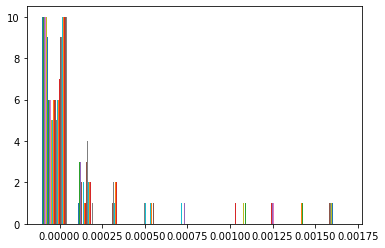

In [48]:
import matplotlib.pyplot as plt
n, bins, pathc = plt.hist(x)

In [43]:
specs_z = [calc_zscore(s) for s in specs]
x_z = specs_z[0]
pd.DataFrame(x_z)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-0.290069,-0.290612,-0.283019,-0.283077,-0.286794,-0.291003,-0.293264,-0.290946,-0.289902,-0.297465,...,-0.312240,-0.298891,-0.292233,-0.292414,-0.289245,-0.294706,-0.311008,-0.334730,-0.348320,-0.335536
1,-0.279069,-0.274775,-0.254804,-0.243103,-0.245293,-0.257877,-0.269018,-0.267264,-0.252271,-0.200452,...,-0.264588,-0.275326,-0.277507,-0.263634,-0.237738,-0.237523,-0.259580,-0.276654,-0.270864,-0.245433
2,-0.287888,-0.285584,-0.269606,-0.256605,-0.251463,-0.260878,-0.276584,-0.275854,-0.251166,-0.193290,...,-0.219814,-0.234264,-0.253356,-0.275931,-0.288711,-0.294610,-0.293224,-0.298060,-0.310674,-0.308354
3,-0.237430,-0.250928,-0.267243,-0.280099,-0.284000,-0.284910,-0.282670,-0.275408,-0.272398,-0.269956,...,-0.266002,-0.254854,-0.259896,-0.282029,-0.294470,-0.286510,-0.259346,-0.248446,-0.273353,-0.293334
4,-0.275599,-0.283563,-0.290150,-0.296579,-0.295389,-0.291566,-0.289703,-0.286530,-0.275142,-0.171416,...,-0.172408,-0.265948,-0.280537,-0.289102,-0.285875,-0.273711,-0.268983,-0.293110,-0.328973,-0.335760
5,-0.292684,-0.294212,-0.288275,-0.287225,-0.286478,-0.286294,-0.288254,-0.289096,-0.288054,-0.280492,...,-0.267266,-0.282149,-0.288780,-0.295140,-0.296049,-0.296608,-0.296930,-0.302321,-0.304604,-0.288489
6,-0.281481,-0.287345,-0.289682,-0.293355,-0.291601,-0.287748,-0.287267,-0.288861,-0.292908,-0.300617,...,-0.310690,-0.297129,-0.289177,-0.288855,-0.286323,-0.289549,-0.289397,-0.266381,-0.214574,-0.154426
7,-0.294140,-0.297310,-0.294432,-0.294542,-0.292007,-0.290209,-0.292290,-0.293737,-0.295825,-0.305421,...,-0.311377,-0.297738,-0.290340,-0.286966,-0.278200,-0.279670,-0.288560,-0.284847,-0.251881,-0.202653
8,-0.292918,-0.295145,-0.290479,-0.290731,-0.291163,-0.292497,-0.295132,-0.295391,-0.296822,-0.304637,...,-0.311136,-0.295808,-0.289533,-0.292961,-0.290981,-0.288408,-0.279220,-0.258828,-0.230839,-0.196974
9,-0.296633,-0.299966,-0.297239,-0.297735,-0.296725,-0.297107,-0.300342,-0.301332,-0.302345,-0.311049,...,-0.316821,-0.302975,-0.297360,-0.300960,-0.301542,-0.306627,-0.315275,-0.322899,-0.316358,-0.289468


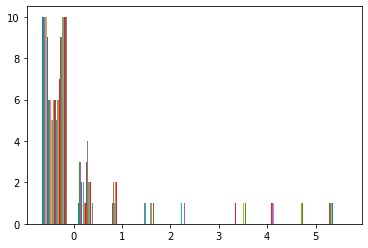

In [49]:
n, bins, pathc = plt.hist(x_z)

In [50]:
specs = [np.where(s<0,0,s) for s in specs_z]
specs = [np.where(s>3,3,s) for s in specs_z]

In [53]:
f = specs[0]
np.min(f)

-0.7137832399749983

In [20]:
def calc_umap(data, outname, metric=DEF_METRIC_TYPE, min_dist=DEF_MIN_DIST, spread=DEF_SPREAD, n_neighbors=DEF_N_NEIGHBORS, n_comps=DEF_N_COMPS,n = 1):
    
    for i in range(n):
        reducer = umap.UMAP(n_components = n_comps, 
                            min_dist=min_dist,
                            spread=spread,
                            n_neighbors=n_neighbors,
                            metric=metric,
                            random_state=1)

        embedding = reducer.fit_transform(data)
        print(outname)
        np.savetxt(outname+'_'+str(i)+'.csv', embedding, delimiter=";")  

In [62]:
# Re-do missing 

for f in missing_in_observed:
    preprocess_type, metric_type, duration_method,min_dist, spread, n_neighbors, n_comps, input_type, denoise, n_mels, f_unit, bp_filtered, n_repeat = get_params_from_filename(f)
    
    min_dist = int(min_dist)
    spread = int(spread)
    n_neighbors = int(n_neighbors)
    n_comps = int(n_comps)
    n_mels = int(n_mels)
    
    outname = os.path.join(os.path.sep, OUT_COORDS, get_param_string())
    
    try:
                                # select dataframe column
        #print("SELECT")
        if bp_filtered=='yes':
            if duration_method=='stretched':
                specs = spec_df.raw_specs_filtered_stretched.copy()
            else:
                specs = spec_df.raw_specs_filtered.copy()
        else:
            if duration_method=='stretched':
                specs = spec_df.raw_specs_stretched.copy()
            else:
                specs = spec_df.raw_specs.copy()
    except:
        print("FAILED SELECT: ", get_param_string())



    try:                            # Mel transform
        #print("n_mels")
        if n_mels>0:
            #print("LAGGA")
            srs = spec_df.samplerate_hz.copy()
            specs = [librosa.feature.melspectrogram(S=s, sr=sr, n_mels=n_mels, fmax=FMAX) for s, sr in zip(specs, srs)]
        else:
                                    # Problem: Because of the varying samplerate, the non-mel-transformed spectrograms are not all of the same height!!
                                    # So if I'm using them, I need to cut the ones with the more frequency range.
            #print("SMALLE")
            n_bins = [s.shape[0] for s in specs]
            min_bins = np.min(n_bins)
            specs = [s[0:min_bins,:] for s in specs]
        #print("NEMELS")
    except:
        print("FAILED MEL: ", get_param_string())

        
    try:
                                # Spectrogram intensity unit
        #print("UNIT")
        if f_unit=="dB":
            specs = [librosa.power_to_db(s, ref=np.max) for s in specs]

    except:
        print("FAILED INTENSITY UNIT: ", get_param_string())

                                # Denoising
    if denoise=='yes':
        specs = [(s-np.median(s, axis=0)) for s in specs]

    try: 
        #print("OPREPRO")# Pre-processing
        if preprocess_type=='zs':
            specs = [calc_zscore(s) for s in specs]
        elif preprocess_type=='zs-fl-ce':
            specs = [calc_zscore(s) for s in specs] 
            specs = [np.where(s<0,0,s) for s in specs]
            specs = [np.where(s>3,3,s) for s in specs]

    except:
        print("FAILED PREPROCESS: ", get_param_string())

    
    try:
        #print("trnasform")
        n_bins = specs[0].shape[0]
        maxlen = np.max([spec.shape[1] for spec in specs]) * n_bins + 2
        trans_specs = [pad_transform_spectro(spec, maxlen) for spec in specs]
        data = np.asarray(trans_specs)
    except:
        print("FAILED DATA PREP: ", get_param_string())



                                    # set spec_dist depending on metric_type!!
    if metric_type=='euclidean':
        @numba.njit()
        def spec_dist(a,b,size):
            dist = np.sqrt((np.sum(np.subtract(a,b)*np.subtract(a,b)))) / np.sqrt(size)
            return dist

    elif metric_type=='manhattan':
        @numba.njit()
        def spec_dist(a,b,size):
            dist = (np.sum(np.abs(np.subtract(a,b)))) / size
            return dist

    elif metric_type=='cosine':
        @numba.njit()
        def spec_dist(a,b,size):
                                            # turn into unit vectors by dividing each vector field by magnitude of vector
            dot_product = np.sum(a*b)
            a_magnitude = np.sqrt(np.sum(a*a))
            b_magnitude = np.sqrt(np.sum(b*b))
            if (a_magnitude*b_magnitude)==0:
                dist=0
            else:
                dist = 1 - dot_product/(a_magnitude*b_magnitude)
            return dist

    elif metric_type=='correlation':
        @numba.njit()
        def spec_dist(a,b,size):
            a_meandiff = a - np.mean(a)
            b_meandiff = b - np.mean(b)
            dot_product =  np.sum(a_meandiff*b_meandiff)                                  
            a_meandiff_magnitude = np.sqrt(np.sum(a_meandiff*a_meandiff))
            b_meandiff_magnitude = np.sqrt(np.sum(b_meandiff*b_meandiff))
            if (a_meandiff_magnitude * b_meandiff_magnitude)==0:
                dist = 0
            else:
                dist = 1 - dot_product/(a_meandiff_magnitude * b_meandiff_magnitude)
            return dist
            
            
            
    if duration_method=='timeshift-overlap':
        #print("CHEFDDF")
        @numba.njit()
        def calc_timeshift(a,b):
            spec_s, spec_l = unpack_specs(a,b)  
            len_l = spec_l.shape[1]
            len_s = spec_s.shape[1]


                                                # define start position
            min_overlap_frames = int(MIN_OVERLAP * len_s)
            start_timeline = min_overlap_frames-len_s
            max_timeline = len_l - min_overlap_frames

            n_of_calculations = (max_timeline+1-start_timeline)+(max_timeline+1-start_timeline)

            distances = np.full((n_of_calculations),999.)

            count=0

            for timeline_p in range(start_timeline, max_timeline+1):
                                                    # mismatch on left side
                if timeline_p < 0:
                    start_col_l = 0
                    len_overlap = len_s - abs(timeline_p)

                    end_col_l = start_col_l + len_overlap

                    end_col_s = len_s # until the end
                    start_col_s = end_col_s - len_overlap

                                                    # mismatch on right side
                elif timeline_p > (len_l-len_s):
                    start_col_l = timeline_p
                    len_overlap = len_l - timeline_p
                    end_col_l = len_l

                    start_col_s = 0
                    end_col_s = start_col_s + len_overlap

                                                    # no mismatch on either side
                else:
                    start_col_l = timeline_p
                    len_overlap = len_s
                    end_col_l = start_col_l + len_overlap

                    start_col_s = 0
                    end_col_s = len_s # until the end


                s_s = spec_s[:,start_col_s:end_col_s].astype(np.float64)
                s_l = spec_l[:,start_col_l:end_col_l].astype(np.float64)
                size = s_s.shape[0]*s_s.shape[1]
                distances[count] = spec_dist(s_s, s_l, size)

                count = count + 1

            min_dist = np.min(distances)                                              
            return min_dist
                
        try:
            calc_umap(data, outname=outname, metric = calc_timeshift)
        except:
            print("FAILED UMAP: ", get_param_string())

/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_cosine_timeshift-overlap_0_1_15_3_specs_no_40_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_yes_10_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_10_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_20_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_yes


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_30_magnitude_no


/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/interim/parameter_search/grid_search/zs-fl-ce_correlation_timeshift-overlap_0_1_15_3_specs_no_40_magnitude_no
